<a href="https://colab.research.google.com/github/KaterinaKintiDS/open-data/blob/master/MT4FocalLoss0_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pickle
pd.set_option('display.max_columns', 350)
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from statistics import mean, stdev
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, chi2, RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

import imblearn
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.compose import ColumnTransformer
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
import functools
from sklearn.model_selection import LeaveOneOut, cross_validate, KFold, GridSearchCV, RandomizedSearchCV,cross_val_score, RepeatedStratifiedKFold, StratifiedKFold

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, classification_report, roc_auc_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.metrics import fbeta_score, make_scorer, recall_score, log_loss, confusion_matrix, precision_recall_curve, auc,accuracy_score, precision_score,  roc_curve
from sklearn.metrics import average_precision_score,precision_recall_curve, auc,  accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from tabulate import tabulate
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
qual = pd.read_pickle("FinTech3_2000.pkl")

In [ ]:
# reset index
qual.sort_index(inplace=True)
qual.head()


,IDacc,SNAPNUMacc,MEAS_ACCH_ORIGINATOR,MEAS_ACCL_STRAY_PAYMENT_AMT,MEAS_ACCL_APLL_IS_NEW,MEAS_ACCL_APLL_FORBORNE,MEAS_ACCL_APPL_TYPE,MEAS_ACCL_PAID_IN_FULL_CM,MEAS_ACCL_APPLICATION_SUCCESSFUL,MEAS_ACCL_UNDERWRITING_SEGMENT,MEAS_ACCL_PROMISE_ACCOUNTS,MEAS_ACCL_PROMISE_ACCOUNT,MEAS_ACCL_KEPT_ACCOUNT,MEAS_ACCL_KEPT_PROMISE,MEAS_ACCL_NUM_OF_PROMISES,MEAS_ACCL_HAS_ARRANGEMENT_FLAG,MEAS_ACCL_BROKEN_SETTLEMENT_INDICATOR_CP,MEAS_ACCL_LAST_CONTACT_TYPE,MEAS_ACCL_LAST_CONTACT_STRATEGY,MEAS_ACCL_NBR_OF_KEPT_PROMISESS,MEAS_ACCL_NBR_OF_KEPT_PROMISES,MEAS_ACCL_NBR_OF_PROMISES,MEAS_ACCL_NBR_OF_UNKEPT_PROMISES,MEAS_ACCL_REQUEST_STATUS,MEAS_ACCH_STATUS_DELINQ,MEAS_ACCH_STATUS,MEAS_ACCL_STATUS_PRIORITY,MEAS_ACCL_STATUS_SKIP,MEAS_ACCL_BUCKET_MAX_NBG,MEAS_ACCH_CATEG_SEGMENT,MEAS_ACCL_COOPERATIVE,MEAS_ACCL_BILLING_DAY,MEAS_ACCT_BRANCH,MEAS_ACCH_BUSUNIT,MEAS_ACCH_CURRENCY,MEAS_ACCH_ACTIVE,MEAS_ACCH_DELDAYS,MEAS_ACCH_QC_ISCASE,MEAS_ACCH_QC_ISCONTRACT,MEAS_ACCH_PERIODICITY,MEAS_ACCL_RELATION_TYPE_DESC,MEAS_ACCH_COUNT_RESCHEDULINGS,MEAS_ACCL_CASE_SOURCE,MEAS_ACCH_CATEG_TYPE,MEAS_ACCH_FLAG_LITIGATION,MEAS_ACCL_SECONDARY_FLOW_FLAG,MEAS_ACCH_STATUS_LITIGATION,MEAS_ACCH_FLAG_COSIGNER,MEAS_ACCH_FLAG_GUARANTOR,MEAS_ACCL_NUMBER_OF_COLLATERALS,MEAS_ACCL_PAYMENT_IN_ALLOCATION,MEAS_ACCH_FLAG_SECURED,MEAS_ACCT_CUST_CODE,MEAS_ACCL_DEPARTMENT_AT_ALLOCATION,MEAS_ACCL_INDICATION_CONTACT_ANY_CP,MEAS_ACCL_INDICATION_CONTACT_ATTEMPT_CP,MEAS_ACCL_INDICATION_CONTACT_RIGHTPERSON_CP,MEAS_ACCL_MAX_CONTACTTYPE,MEAS_ACCL_ALLOCATION_CODE,MEAS_ACCH_DELINQ_PACKAGE_TYPE,MEAS_PROD_CODE,MEAS_ACCL_DEBT_REDUCTION_RULE,MEAS_ACCH_SNAPNUM,MEAS_SPRD_CODE,MEAS_ACCH_DELINQ_STRATEGY,MEAS_ACCH_DELINQ_STEP,MEAS_ACCL_CONTACT_NUM_ATTEMPTS_CP,MEAS_ACCL_CONTACT_NUM_RPC_CP,MEAS_ACCL_CONTACT_RPC_TYPE_LATEST,MEAS_ACCH_CATEG_CLASS_ASSET,MEAS_ACCL_HAS_WEB_ACCOUNT,MEAS_ACCL_HAS_PHONE_NUMBER,MEAS_ACCL_HAS_CONTACT_ATTEMPT,MEAS_ACCL_SUBMISSION_AFTER_CONTACT,MEAS_ACCL_DPD_GROUP,MEAS_ACCL_BUS_SIZE,MEAS_ACCL_PUBLIC_SECTOR,MEAS_ACCL_FLAG_DENOUNCED,MEAS_ACCL_EBA_FORBORNE,MEAS_ACCL_NUMBER_OF_GUARANTORS,MEAS_ACCL_HAS_FIRST_LETTER,MEAS_ACCL_HAS_SECOND_LETTER,MEAS_ACCL_LETTER_RECEIVED,MEAS_ACCL_FIRST_CONTACT_ATTEMPT_NM,MEAS_ACCL_BROKEN_BUCKET_4,MEAS_ACCL_ACTUAL_CONTACTS,MEAS_ACCL_ACTUAL_CONTACTS_PM,MEAS_ACCL_HAS_COLLATERAL,MEAS_ACCL_PAID_IN_FULL,MEAS_ACCL_PAYMENT_RECONCILIATION_CODE,MEAS_ACCL_FLAG_OPEN_RECENTLY,MEAS_ACCL_PHONE_RPC_COUNT_EVER,MEAS_ACCL_EED_PERCENT,MEAS_ACCH_DELINQ_DCA,MEAS_ACCL_PHONE_RPC_DCA_FIRST,MEAS_ACCL_PHONE_RPC_DCA_LATEST,MEAS_ACCL_DELINQ_DCA_GROUPING,MEAS_ACCL_PREVIOUS_3RD_PARTY_NAME,MEAS_ACCL_PAYMENTS_REPAYMENT_PLAN_CP,MEAS_ACCL_PAYMENTS_ONEOFF_YTD,MEAS_ACCL_PAYMENTS_REPAYMENT_PLAN_YTD,MEAS_ACCL_PAYMENTS_NO_SETTLEMENT_YTD,MEAS_ACCL_AMT_PROMISE,MEAS_ACCL_AMT_KEPT,MEAS_ACCL_ARRANGEMENT_PRINCIPAL,MEAS_ACCL_ARRANGEMENT_BALANCE,MEAS_ACCL_AMT_INSTAL_NOT_MATURED_CM,MEAS_ACCL_APPL_AMT_APPROVED,MEAS_ACCL_APPL_AMT_DUNNING,MEAS_ACCL_APPL_AMT_APPROVED_NEW,MEAS_ACCL_APPL_AMT_FALLOFF,MEAS_ACCL_LMEM_PAYMENTS_CP,MEAS_ACCL_LMEM_PAYMENTS_CUMUL,MEAS_ACCL_AMT_PAYMENTS_TOTAL,MEAS_ACCL_AMT_OVERPAYMENT_ADDITIONAL,MEAS_ACCL_AMT_PAYMENT_YTD,MEAS_ACCH_AMT_PASTDUE,MEAS_ACCL_AMT_DENOUNCED,MEAS_ACCL_AMT_DUE_NBG,MEAS_ACCL_AMT_PAYMENT_REMAINING,MEAS_ACCH_AMT_BAL_ACCOUNTING,MEAS_ACCL_AMT_ORIG_EXPENSES,MEAS_ACCL_AMT_ORIG_INTEREST_OFFBALANCE,MEAS_ACCL_AMT_ORIG_INTEREST_ONBALANCE,MEAS_ACCL_AMT_ORIG_PRINCIPAL,MEAS_ACCL_AMT_ORIG_CLAIM_PNI,MEAS_ACCL_AMT_OVERPAYMENT,MEAS_ACCH_AMT_EXPENSES,MEAS_ACCL_AMT_INTEREST_OFFBALANCE,MEAS_ACCL_AMT_INTEREST_ONBALANCE,MEAS_ACCH_AMT_PRINCIPAL,MEAS_ACCL_AMT_CLAIM_PNI,MEAS_ACCL_AMT_CLAIM_G3,MEAS_ACCL_DUE_PRINCIPAL,MEAS_ACCL_AMT_CLAIM_G4,MEAS_ACCL_AMT_PRINCIPAL_TOTAL,MEAS_ACCL_AMT_GBV,MEAS_ACCH_AMT_LIMIT,MEAS_ACCL_DEFAULT_BALANCE,MEAS_ACCH_AMT_ARREARS,MEAS_ACCL_LATE_INTEREST,MEAS_ACCL_INTEREST,MEAS_ACCH_AMT_MINPAYMENT,MEAS_ACCH_AMT_BALANCE,MEAS_ACCL_PURCHASE_BALANCE,MEAS_ACCH_AMT_WRITEOFF,MEAS_ACCH_AMT_PAYMENT_LAST,MEAS_ACCL_COLLATERALS_VALUE,MEAS_ACCL_COLLA_MARKET_VALUE,MEAS_ACCL_AMT_BAL_ACCOUNT

In [ ]:
# Sorting by timestamp
#sorted = qual.sort_values(by='months_since_2000_MEAS_ACCH_DATE_LITIGATION')
#months_since_2000_MEAS_ACCH_DATE_OPENED, months_since_2000_MEAS_ACCH_DATE_INSTALMENT_NEXT,months_since_2000_MEAS_CUSL_FIRST_DEFAULT_DATE, months_since_2000_MEAS_ACCH_DATE_PAYMENT_LAST, months_since_2000_MEAS_ACCH_DATE_EXP
sorted = qual.sort_values(by='months_since_2000_MEAS_ACCH_DATE_DENOUNCED')

In [ ]:
# Separate the features and target variable
X = sorted.drop(['IDacc', 'SNAPNUMacc','Target', 'IDcus', 'SNAPNUMcus'], axis=1)
y = sorted['Target']

In [ ]:
# calculate percentage of each class of target variable
class_ratio = y.value_counts(normalize=True) * 100
class_ratio

Target
0    99.80796
1     0.19204
Name: proportion, dtype: float64

In [ ]:
#Count classes
"Class distribution:", Counter(y)

('Class distribution:', Counter({0: 413701, 1: 796}))

In [ ]:
# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

# One-hot encode categorical features using get_dummies
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)


# Concatenate numerical columns from X with the one-hot encoded X
X_combined = pd.concat([X[numerical_columns], X_encoded], axis=1)


In [ ]:
X_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 414497 entries, 2763299 to 2159043
Columns: 4166 entries, MEAS_ACCH_ORIGINATOR to MEAS_CUSL_HAS_CONTACT_ATTEMPT_Yes
dtypes: bool(3857), float64(210), int32(25), int64(74)
memory usage: 2.4 GB


In [ ]:
unique_classes, class_counts = np.unique(y, return_counts=True)
print("Class Distribution of y:", dict(zip(unique_classes, class_counts)))

Class Distribution of y: {0: 413701, 1: 796}


In [ ]:
# Split the sorted data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print("Class Distribution in Training Set:", dict(zip(unique_classes, class_counts)))

Class Distribution in Training Set: {0: 330960, 1: 637}


In [ ]:
unique_classes, class_counts = np.unique(y_test, return_counts=True)
print("Class Distribution in Testing Set:", dict(zip(unique_classes, class_counts)))

Class Distribution in Testing Set: {0: 82741, 1: 159}


In [ ]:
# calculate percentage of each class of target variable
class_ratio = y_train.value_counts(normalize=True) * 100
class_ratio

Target
0    99.807899
1     0.192101
Name: proportion, dtype: float64

In [ ]:
# calculate percentage of each class of target variable
class_ratio = y_test.value_counts(normalize=True) * 100
class_ratio

Target
0    99.808203
1     0.191797
Name: proportion, dtype: float64

In [ ]:
# Use MinMaxScaler instead of RobustScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# SelectKBest, instead of SelectFromModel /δοκιμή με 'f_classif'
k_best = 250
select_k_best = SelectKBest(chi2, k=k_best)
X_train_k_best = select_k_best.fit_transform(X_train_scaled, y_train)
X_test_k_best = select_k_best.transform(X_test_scaled)

In [ ]:
#RFE with RandomForestClassifier / XGBoost didn't gave good results / RFECV didn't run / δοκιμή χωρίς RFE

rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=100)
X_train_rfe = rfe.fit_transform(X_train_k_best, y_train)
X_test_rfe = rfe.transform(X_test_k_best)

In [ ]:
# Get the indices of the selected features after RFE
selected_feature_indices_rfe = np.where(rfe.support_)[0]


# Get the column names based on the selected indices
selected_column_names_rfe = X_combined.columns[selected_feature_indices_rfe]
selected_column_names_list = selected_column_names_rfe.tolist()


# Print the list of selected column names
print("Selected Column Names after RFE:", selected_column_names_list)


Selected Column Names after RFE: ['MEAS_ACCL_APLL_FORBORNE', 'MEAS_ACCL_HAS_ARRANGEMENT_FLAG', 'MEAS_ACCL_BROKEN_SETTLEMENT_INDICATOR_CP', 'MEAS_ACCL_NBR_OF_PROMISES', 'MEAS_ACCL_NBR_OF_UNKEPT_PROMISES', 'MEAS_ACCL_STATUS_PRIORITY', 'MEAS_ACCL_BUCKET_MAX_NBG', 'MEAS_ACCL_BILLING_DAY', 'MEAS_ACCT_BRANCH', 'MEAS_ACCH_DELDAYS', 'MEAS_ACCH_QC_ISCASE', 'MEAS_ACCH_COUNT_RESCHEDULINGS', 'MEAS_ACCL_SECONDARY_FLOW_FLAG', 'MEAS_ACCH_FLAG_COSIGNER', 'MEAS_ACCH_FLAG_GUARANTOR', 'MEAS_ACCL_NUMBER_OF_COLLATERALS', 'MEAS_ACCL_PAYMENT_IN_ALLOCATION', 'MEAS_ACCT_CUST_CODE', 'MEAS_ACCL_INDICATION_CONTACT_ANY_CP', 'MEAS_ACCL_INDICATION_CONTACT_RIGHTPERSON_CP', 'MEAS_ACCL_CONTACT_NUM_RPC_CP', 'MEAS_ACCL_AMT_INSTAL_NOT_MATURED_CM', 'MEAS_ACCL_APPL_AMT_APPROVED', 'MEAS_ACCL_AMT_DENOUNCED', 'MEAS_ACCL_AMT_PAYMENT_REMAINING', 'MEAS_ACCH_AMT_BAL_ACCOUNTING', 'MEAS_ACCL_AMT_ORIG_EXPENSES', 'MEAS_ACCL_AMT_ORIG_INTEREST_OFFBALANCE', 'MEAS_ACCH_AMT_EXPENSES', 'MEAS_ACCL_AMT_CLAIM_PNI', 'MEAS_ACCL_DUE_PRINCIPAL', '

In [ ]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print("Class Distribution in Training Set:", dict(zip(unique_classes, class_counts)))


Class Distribution in Training Set: {0: 330960, 1: 637}


In [ ]:
#Highly imbalanced dataset, both oversample and undersample */ δοκιμή με άλλη αναλογία
resampling_strategy = {
    'minority': 0.3,
    'majority': 0.5
}

# Create a pipeline with SMOTE and RandomUnderSampler
pipeline = Pipeline([
    ('oversample', SMOTE(sampling_strategy=resampling_strategy['minority'], n_jobs=-1)),
    ('undersample', RandomUnderSampler(sampling_strategy=resampling_strategy['majority']))
])

# Fit and transform the training data
X_train_resampled, y_train_resampled = pipeline.named_steps['oversample'].fit_resample(X_train_rfe, y_train)
X_train_resampled, y_train_resampled = pipeline.named_steps['undersample'].fit_resample(X_train_resampled, y_train_resampled)


  File "C:\Users\Katerina\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Katerina\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Katerina\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Katerina\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [ ]:
# Check the class distribution before and after SMOTE
class_distribution_before = pd.Series(y_train).value_counts(normalize=True)
class_distribution_after = pd.Series(y_train_resampled).value_counts(normalize=True)

print("Class Distribution Before SMOTE:")
print(class_distribution_before)

print("\nClass Distribution After SMOTE:")
print(class_distribution_after)

Class Distribution Before SMOTE:
Target
0    0.998079
1    0.001921
Name: proportion, dtype: float64

Class Distribution After SMOTE:
Target
0    0.666667
1    0.333333
Name: proportion, dtype: float64


In [ ]:
# calculate percentage of each class of target variable
class_ratio = y_test.value_counts(normalize=True) * 100
class_ratio

Target
0    99.808203
1     0.191797
Name: proportion, dtype: float64

In [ ]:
from prettytable import PrettyTable
# Create a table
table = PrettyTable()
#model_labels = ["Random Forest", "XGBoost", "Focal Loss", "Weighted Loss", "Grid Search_Base Model", "Grid Search_Focal Loss", "Grid Search_Weighted Loss"]
table.field_names = ["Model", "ROC-AUC", "Precision-Recall AUC"]

Random Forest

In [ ]:
# fit Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on the test set
y_pred_proba = rf.predict_proba(X_test_rfe)[:, 1]

# Evaluate ROC-AUC
roc_auc_rf = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC: {roc_auc_rf:.4f}')

ROC-AUC: 0.5257


In [ ]:
#Precision-Recall AUC
pr_auc_rf = average_precision_score(y_test, y_pred_proba)
print(f'Precision-Recall AUC: {pr_auc_rf:.4f}')
table.add_row(["Random Forest", f"{roc_auc_rf:.4f}", f"{pr_auc_rf:.4f}"])


Precision-Recall AUC: 0.0021


In [ ]:
# Classification Report
y_pred = rf.predict(X_test_rfe)
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     82741
           1       0.00      0.03      0.01       159

    accuracy                           0.98     82900
   macro avg       0.50      0.51      0.50     82900
weighted avg       1.00      0.98      0.99     82900



XGBoost

In [ ]:
# XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on the test set
y_pred_proba = xgb.predict_proba(X_test_rfe)[:, 1]

# Evaluate ROC-AUC
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC: {roc_auc_xgb:.4f}')

ROC-AUC: 0.5786


In [ ]:
#Precision-Recall AUC
pr_auc_xgb = average_precision_score(y_test, y_pred_proba)
print(f'Precision-Recall AUC: {pr_auc_xgb:.4f}')
table.add_row(["XGBoost", f"{roc_auc_xgb:.4f}", f"{pr_auc_xgb:.4f}"])

Precision-Recall AUC: 0.0025


In [ ]:
# Classification Report
y_pred = xgb.predict(X_test_rfe)
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82741
           1       0.00      0.00      0.00       159

    accuracy                           0.99     82900
   macro avg       0.50      0.50      0.50     82900
weighted avg       1.00      0.99      1.00     82900



Focal loss

In [ ]:
y_train_resampled = y_train_resampled.to_numpy().flatten()

In [ ]:
def score_eval_func(y_test, y_pred_prob):
    roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])
    pr_auc = average_precision_score(y_test, y_pred_prob[:, 1])
    return roc_auc, pr_auc


In [ ]:
#In FC the scaling factor decays to zero as confidence in the correct class increases
# down-weights the loss assigned to well-classified examples. easy examples are given less weight than misclassified examples.
# Instantiate imbalance-xgboost instance with focal loss
xgbooster_focal = imb_xgb(special_objective='focal', focal_gamma=2.0)

# Fit the model on the entire dataset
xgbooster_focal.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on the test set
# Evaluate ROC-AUC and Precision-Recall AUC
y_pred_prob_focal = xgbooster_focal.predict_two_class(X_test_rfe, y=None)
roc_auc_focal, pr_auc_focal = score_eval_func(y_test, y_pred_prob_focal)
print(f'ROC-AUC (Focal Loss): {roc_auc_focal:.4f}, Precision-Recall AUC: {pr_auc_focal:.4f}')
table.add_row(["Focal Loss", f"{roc_auc_focal:.4f}", f"{pr_auc_focal:.4f}"])

ROC-AUC (Focal Loss): 0.6240, Precision-Recall AUC: 0.0031


Weighted loss

In [ ]:
#The weights are used to assign a higher penalty to misclassifications of minority class.
# Instantiate imbalance-xgboost instance with weighted loss
xgbooster_weight = imb_xgb(special_objective='weighted', imbalance_alpha=2.0)


# Fit the model on the entire dataset
xgbooster_weight.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on the test set
# Evaluate ROC-AUC and Precision-Recall AUC
y_pred_prob_weight = xgbooster_weight.predict_two_class(X_test_rfe, y=None)
roc_auc_weight, pr_auc_weight = score_eval_func(y_test, y_pred_prob_weight)
print(f'ROC-AUC (Weighted Loss): {roc_auc_weight:.4f}, Precision-Recall AUC: {pr_auc_weight:.4f}')
table.add_row(["Weightd Loss", f"{roc_auc_weight:.4f}", f"{pr_auc_weight:.4f}"])

ROC-AUC (Weighted Loss): 0.6228, Precision-Recall AUC: 0.0028


Grid Search

In [ ]:
# Define the XGBoost classifier for all three scenarios
xgb = XGBClassifier(random_state=42)

# Function to evaluate results
def score_eval_func(y_test, y_pred_prob):
    # Calculate ROC-AUC and Precision-Recall AUC
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)

    return roc_auc, pr_auc

# Base model Grid Search
param_grid_base = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [7, 9],
    'subsample': [1.0, 1.2],
    'scale_pos_weight': [5, 7],
    'n_estimators': [200, 300],
}

grid_search_base = GridSearchCV(xgb, param_grid_base, scoring='roc_auc', cv=3)
grid_search_base.fit(X_train_resampled, y_train_resampled)
opt_base_booster = grid_search_base.best_estimator_

# Predict probabilities on the test set for the base model
y_pred_prob_base = opt_base_booster.predict_proba(X_test_rfe)[:, 1]

# Evaluate ROC-AUC and Precision-Recall AUC
roc_auc_gs, pr_auc_gs = score_eval_func(y_test, y_pred_prob_base)
print(f'Base Model - ROC-AUC: {roc_auc_gs:.4f}, Precision-Recall AUC: {pr_auc_gs:.4f}')
table.add_row(["Grid Search Base", f"{roc_auc_gs:.4f}", f"{pr_auc_gs:.4f}"])

Base Model - ROC-AUC: 0.5771, Precision-Recall AUC: 0.0024


In [ ]:
# Focal Loss model Grid Search
param_grid_focal = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [7, 9],
    'subsample': [1.0, 1.2],
    'scale_pos_weight': [5, 7],
    'n_estimators': [200, 300],
    'focal_gamma': [1.0, 3.0],
}

grid_search_focal = GridSearchCV(xgb, param_grid_focal, scoring='roc_auc', cv=3)
grid_search_focal.fit(X_train_resampled, y_train_resampled)
opt_focal_booster = grid_search_focal.best_estimator_

# Predict probabilities on the test set for the focal loss model
y_pred_prob_focal = opt_focal_booster.predict_proba(X_test_rfe)[:, 1]

# Evaluate ROC-AUC and Precision-Recall AUC
roc_auc_gs_focal, pr_auc_gs_focal = score_eval_func(y_test, y_pred_prob_focal)
print(f'Focal Loss Model - ROC-AUC: {roc_auc_gs_focal:.4f}, Precision-Recall AUC: {pr_auc_gs_focal:.4f}')
table.add_row(["Focal Loss model Grid Search", f"{roc_auc_gs_focal:.4f}", f"{pr_auc_gs_focal:.4f}"])

Focal Loss Model - ROC-AUC: 0.5771, Precision-Recall AUC: 0.0024


In [ ]:
# Weighted Loss model Grid Search
param_grid_weight = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [7, 9],
    'subsample': [1.0, 1.2],
    'scale_pos_weight': [5, 7],
    'n_estimators': [200, 300],
    'imbalance_alpha': [1.0, 3.0],
}

grid_search_weight = GridSearchCV(xgb, param_grid_weight, scoring='roc_auc', cv=3)
grid_search_weight.fit(X_train_resampled, y_train_resampled)
opt_weight_booster = grid_search_weight.best_estimator_

# Predict probabilities on the test set for the weighted loss model
y_pred_prob_weight = opt_weight_booster.predict_proba(X_test_rfe)[:, 1]

# Evaluate ROC-AUC and Precision-Recall AUC for the weighted loss model
roc_auc_gs_weight, pr_auc_gs_weight = score_eval_func(y_test, y_pred_prob_weight)
print(f'Weighted Loss Model - ROC-AUC: {roc_auc_gs_weight:.4f}, Precision-Recall AUC: {pr_auc_gs_weight:.4f}')
table.add_row(["Weighted Loss model Grid Search", f"{roc_auc_gs_weight:.4f}", f"{pr_auc_gs_weight:.4f}"])

Weighted Loss Model - ROC-AUC: 0.5771, Precision-Recall AUC: 0.0024


In [ ]:
print(table)

+---------------------------------+---------+----------------------+
|              Model              | ROC-AUC | Precision-Recall AUC |
+---------------------------------+---------+----------------------+
|          Random Forest          |  0.5257 |        0.0021        |
|             XGBoost             |  0.5786 |        0.0025        |
|            Focal Loss           |  0.6240 |        0.0031        |
|           Weightd Loss          |  0.6228 |        0.0028        |
|         Grid Search Base        |  0.5771 |        0.0024        |
|   Focal Loss model Grid Search  |  0.5771 |        0.0024        |
| Weighted Loss model Grid Search |  0.5771 |        0.0024        |
+---------------------------------+---------+----------------------+


Winning : Focal Loss

In [ ]:
# Use the original features and target variable for splitting
X = X_train_resampled
y = y_train_resampled

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print("Class Distribution in Training Set:", dict(zip(unique_classes, class_counts)))

Class Distribution in Training Set: {0: 139003, 1: 69501}


In [ ]:
unique_classes, class_counts = np.unique(y_val, return_counts=True)
print("Class Distribution in Training Set:", dict(zip(unique_classes, class_counts)))

Class Distribution in Training Set: {0: 29786, 1: 14894}


In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_prob = xgb.predict_proba(X_val)

# Extract probabilities for the positive class (class 1)
y_pred_prob_val = y_pred_prob[:, 1]

# Set a threshold to convert probabilities to binary predictions
threshold = 0.5
y_pred_binary = (y_pred_prob_val >= threshold).astype(int)

In [ ]:
# Calculate precision-recall curve
precision_val, recall_val, thresholds = precision_recall_curve(y_val, y_pred_prob_val)

# Calculate area under the precision-recall curve
pr_auc_val = auc(recall_val, precision_val)

# Find the optimal threshold that maximizes Precision-Recall AUC
optimal_index = np.argmax(pr_auc_val)
optimal_threshold = thresholds[optimal_index]

print("Precision-Recall AUC (Validation):", pr_auc_val)
print("Optimal Threshold (Validation):", optimal_threshold)

Precision-Recall AUC (Validation): 0.9915011012395569
Optimal Threshold (Validation): 1.6730806e-06


In [ ]:
# Evaluate model performance on the validation set using the optimal threshold
#y_pred_val = (y_pred_prob_val >= optimal_threshold).astype(int)

In [ ]:
# Predict probabilities for the test set
y_pred_prob_test = xgb.predict_proba(X_test)

# Calculate ROC AUC score
roc_auc_test = roc_auc_score(y_test, y_pred_prob_test[:, 1])
print("ROC AUC (Test):", roc_auc_test)

ROC AUC (Test): 0.9940227092921077


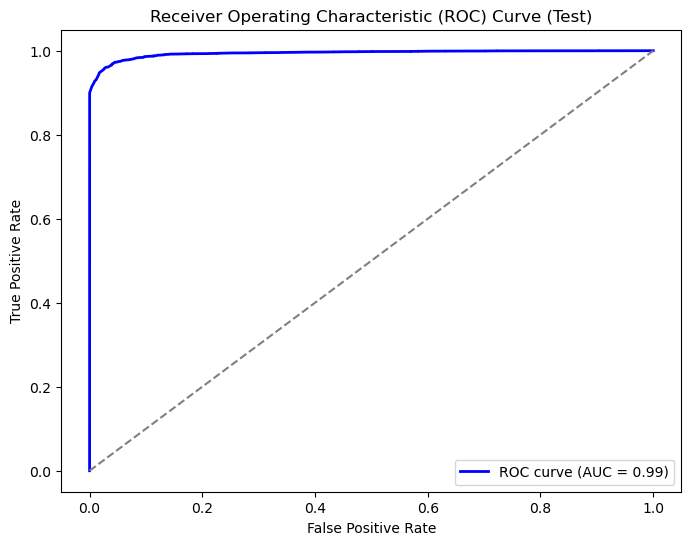

In [ ]:
#ROC curve for the test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_test[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Test)')
plt.legend()
plt.show()

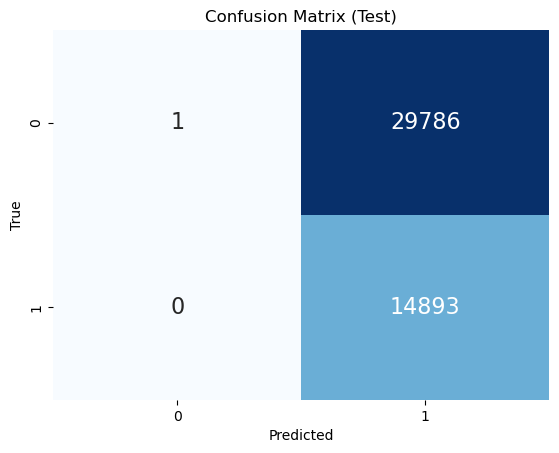

In [ ]:
#Confusion matrix
#shows the correct and incorrect predictions for each class. In the first row, the first column indicates how many classes 0/majority/negative were predicted correctly, and the second column, how many classes 0 were predicted as 1.
# Negative / positive goes along with what your model predicted that observation to be.
#Meaning false negative, means that your model predicted to be negative but it was not ( leftdown)

# Convert predicted probabilities to binary predictions based on a threshold
y_pred_binary_test = (y_pred_prob_test[:, 1] >= optimal_threshold).astype(int)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_test, y_pred_binary_test)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Precision-Recall AUC (Test): 0.9914606345732124


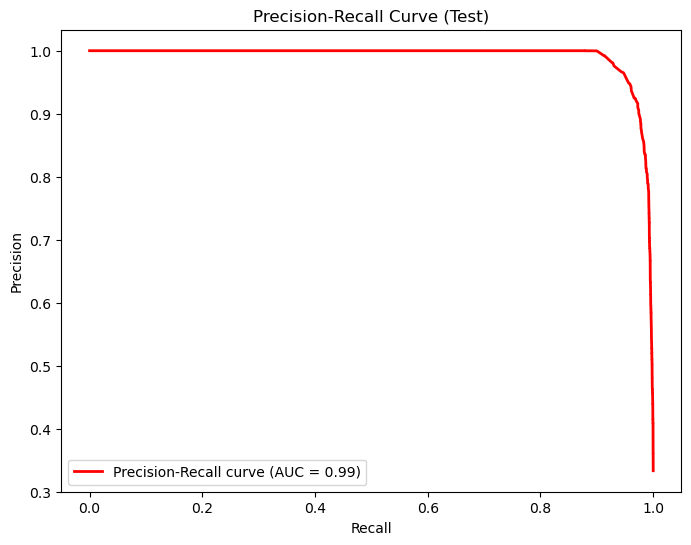

In [ ]:
# Compute Precision-Recall curve for the test set
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_prob_test[:, 1])
pr_auc_test = auc(recall_test, precision_test)

print("Precision-Recall AUC (Test):", pr_auc_test)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_test, precision_test, color='red', lw=2, label='Precision-Recall curve (AUC = {:.2f})'.format(pr_auc_test))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Test)')
plt.legend()
plt.show()

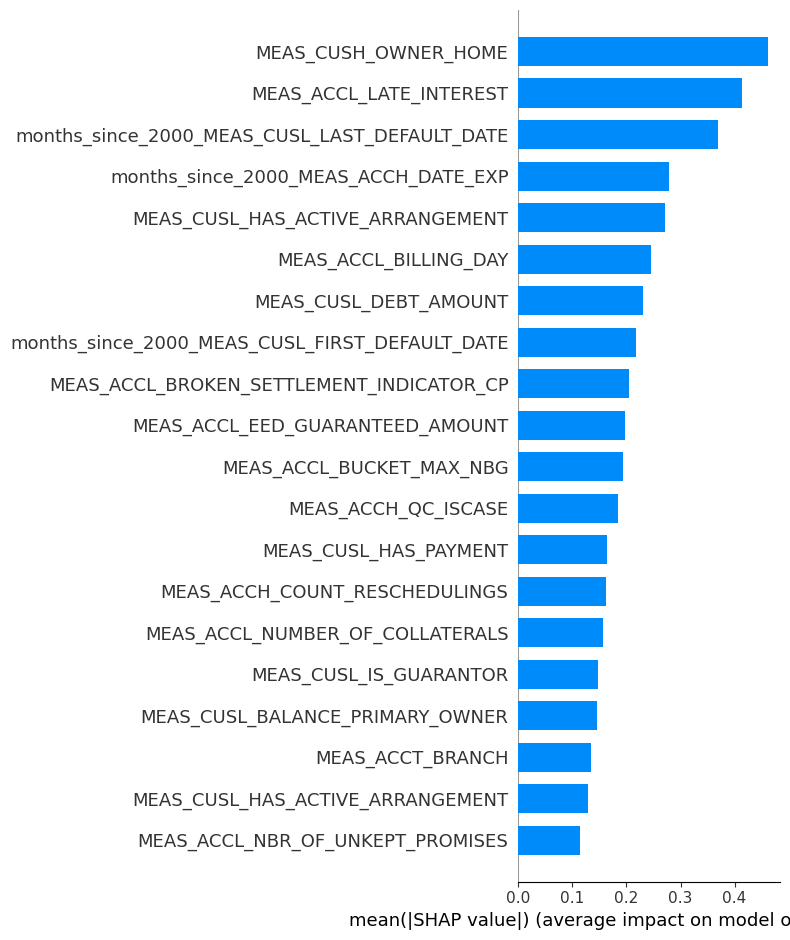

In [ ]:
# Convert X_train and X_test to DataFrames
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

# Get the column names from the DataFrame
feature_names = selected_column_names_list


xgb_model = XGBClassifier()
xgb_model.fit(X_train_df, y_train)

# Create a SHAP explainer using the XGBoost classifier
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test set
shap_values_base = explainer.shap_values(X_test_df)

# Plot summary plot for the first instance in the test set with feature names
shap.summary_plot(shap_values_base, X_test_df, plot_type="bar", feature_names=feature_names)